# LSTM-based Encoder–Decoder  with Keras

# Objectives for this Notebook    
* Build an LSTM-based Encoder–Decoder (Seq2Seq) model with attention using the Keras library
*  Understand how encoder–decoder attention (Bahdanau/Additive Attention) improves sequence-to-sequence learning
* Train an attention-based Seq2Seq model on a given dataset using teacher forcing
* Use the trained model to perform sequence-to-sequence translation
* Analyze model performance by visualizing training loss

<h2>Table of Contents</h2>


<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 4>
1. <a href="#Import-Keras-and-Packages">Import Keras and Packages</a><br>
2. <a href="#Step-1:-Data-Preparation">Step 1: Data Preparation</a><br>
3. <a href="#Step-2:-Self-Attention-Layer">Step 2: Self-Attention Layer</a><br>
4. <a href="#Step-3:-Model-Architecture">Step 3: Model Architecture</a><br>
5. <a href="#Step-4:-Training-the-Model">Step 4: Training the Model</a><br>
6. <a href="#Step-5:-Plotting-the-training-loss">Step 5: Plotting the training loss</a><br>

</font>
</div>


## Import Keras and Packages


Let's start by importing the keras libraries and the packages that we would need to build a neural network.


The following required libraries are __not__ pre-installed in the Skills Network Labs environment. __You will need to run the following cell__ to install them:


In [14]:
!pip install tensorflow_cpu==2.17.1
!pip install matplotlib==3.9.2

print("==== All required libraries are installed =====")

==== All required libraries are installed =====


#### Suppress the tensorflow warning messages

In [15]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

##### To use Keras, you will also need to install a backend framework – such as TensorFlow.
You may install the GPU version of tensorflow on your machine to accelarate the processing of larger datasets


### Import the necessary libraries


In [16]:
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from keras.layers import Layer
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Step 1: Data Preparation
We start by define the sentences and text for translation training
Sentence Pairs: Defines a small dataset of English-Spanish sentence pairs.
Target Sequences:
Prepends "startseq" and appends "endseq" to each target sentence for the decoder to learn when to start and stop translating.


In [17]:
# Sample parallel sentences (English -> Spanish)
input_texts = [
    "Hello.", "How are you?"
]
target_texts = [
    "Hola.", "¿Cómo estás?"
]

target_texts = ["startseq " + x + " endseq" for x in target_texts]

## Next, we convert the text from the sentences to tokens and create a vocabulary
Tokenization: Uses Tokenizer to convert words into numerical sequences.


In [18]:
# Tokenization
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(input_texts)
input_sequences = input_tokenizer.texts_to_sequences(input_texts)

output_tokenizer = Tokenizer()
output_tokenizer.fit_on_texts(target_texts)
output_sequences = output_tokenizer.texts_to_sequences(target_texts)

input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1
print(f"input_vocab_size: {input_vocab_size}")
print(f"output_vocab_size: {output_vocab_size}")

input_vocab_size: 5
output_vocab_size: 6


### Now pad the corresponding sentences
Padding: Ensures all sequences have the same length while masking ignores padded tokens.


In [19]:
# Padding
max_input_length = max([len(seq) for seq in input_sequences])
max_output_length = max([len(seq) for seq in output_sequences])
print(f"max_input_length: {max_input_length}")
print(f"max_output_length: {max_output_length}")

input_sequences = pad_sequences(input_sequences, maxlen=max_input_length, padding='post')
output_sequences = pad_sequences(output_sequences, maxlen=max_output_length, padding='post')
print(f"input_sequences: {input_sequences}")
print(f"output_sequences: {output_sequences}")

max_input_length: 3
max_output_length: 4
input_sequences: [[1 0 0]
 [2 3 4]]
output_sequences: [[1 3 2 0]
 [1 4 5 2]]


In [20]:
# Prepare the target data for training
decoder_input_data = output_sequences[:, :-1]
decoder_output_data = output_sequences[:, 1:]
print(f"decoder_input_data: {decoder_input_data}")
print(f"decoder_output_data: {decoder_output_data}")
# Convert to one-hot
decoder_output_data = np.array([np.eye(output_vocab_size)[seq] for seq in decoder_output_data])

decoder_input_data: [[1 3 2]
 [1 4 5]]
decoder_output_data: [[3 2 0]
 [4 5 2]]


# Step 2: Self-Attention Layer
Self-attention is a mechanism that allows a model to **focus on relevant parts of the input sequence** while processing each word. 


### Self-Attention class
In this implementation of self-attention layer:
1. We first initialize the weights in the **build** method, where:
    1. **self.Wq**, **self.Wk**, **self.Wv** are the trainable weight matrices.
    2. Their **shape is (feature_dim, feature_dim)**, meaning they transform input features into Q, K, and V representations.
2. Applying Attention using **call** method. The **call()** method:
   1. Computes **Q, K, V** by multiplying inputs (encoder/decoder output) with their respective weight matrices.
   2. Computes **dot-product attention scores** using K.batch_dot(q, k, axes=[2, 2]), resulting in a (batch_size, seq_len, seq_len) matrix.
   3. **Scales** the scores to avoid large values.
   4. Applies **softmax** to normalize the attention scores.
   5. **Multiplies attention weights with V** to get the final output.
3. The **compute_output_shape** method defines the shape of the output tensor after the layer processes an input.
    1. The output shape of the Self-Attention layer **remains the same** as the input shape.
    2. The attention mechanism **transforms** the input but does not change its dimensions.4
    3. If the attention layer changed the shape, you would modify compute_output_shape


In [21]:
# Define the Self-Attention Layer
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        feature_dim = input_shape[-1] # Feature dimension (embedding size)
        # Trainable weight matrix to generate Query vectors
        self.Wq = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='glorot_uniform', #sets how the initial values of the weights are generated
                                  trainable=True, # weights updated via backpropagation
                                  name='Wq') # gives the weight variable a name
        # Trainable weight matrix to generate Key vectors
        self.Wk = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='glorot_uniform', 
                                  trainable=True, 
                                  name='Wk')
         # Trainable weight matrix to generate Value vectors
        self.Wv = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='glorot_uniform', 
                                  trainable=True, 
                                  name='Wv')
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        # Linear projections
        q = K.dot(inputs, self.Wq)  # Query
        k = K.dot(inputs, self.Wk)  # Key
        v = K.dot(inputs, self.Wv)  # Value

        # Scaled Dot-Product Attention
        scores = K.batch_dot(q, k, axes=[2, 2])  # (batch, seq_len, seq_len)
        scores = scores / K.sqrt(K.cast(K.shape(k)[-1], dtype=K.floatx()))  # Scale
        attention_weights = K.softmax(scores, axis=-1)  # Normalize

        # Weighted sum of values
        output = K.batch_dot(attention_weights, v)  # (batch, seq_len, feature_dim)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

# Step 3: Model Architecture
The model follows an Encoder-Decoder structure:

### Encoder:
1) Takes input sentences (padded and tokenized).
2) Uses an Embedding layer (word representations) + LSTM (to process sequences).
    1. The LSTMs are used as the **help process variable-length input sentences** and generate meaningful translations.
4) Outputs context vectors (hidden & cell states).

### Attention Layer
1) Applied to both the encoder and decoder outputs.
2) Helps the decoder focus on relevant words during translation.

### Decoder
1) Receives target sequences (shifted one step ahead).
2) Uses an LSTM with encoder states as initial states.
3) Applies self-attention for better learning.
4) Uses a Dense layer (Softmax) to predict the next word.


In [22]:
from tensorflow.keras.layers import AdditiveAttention, Concatenate, Dense, Embedding, Input, LSTM
from tensorflow.keras.models import Model
 
# Encoder
## Encoder input
encoder_inputs = Input(shape=(max_input_length,))
## Embedding layer with 256  LSTM units (also called latent dimension).
encoder_embedding = Embedding(input_vocab_size, 256)(encoder_inputs)
## Encoder LSTM
encoder_lstm = LSTM(256, return_sequences=True, return_state=True)

encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
# encoder_outputs → hidden states for all time steps
# state_h → final hidden state of the encoder LSTM
# state_c → final cell (memory) state of the encoder LSTM
encoder_states = [state_h, state_c]
 
# Decoder input
decoder_inputs = Input(shape=(max_output_length - 1,))
# Decoder embedding
decoder_embedding = Embedding(output_vocab_size, 256)(decoder_inputs)
# Decoder LSTM (initialized with encoder states)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

 
# Attention: decoder attends to encoder outputs
attention = AdditiveAttention()
attention_output = attention([decoder_outputs, # Decoder outputs → queries
                              encoder_outputs] # Encoder outputs → keys & values
                            )
# APPLY SELF-ATTENTION HERE
#self_attention = SelfAttention(name="encoder_self_attention")
#attention_output = self_attention(encoder_outputs)

# Combine decoder outputs with attention context
decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention_output])
 
# Final Dense layer
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat)
 
# Full Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
# Summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 3, 256)    │      1,280 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 3, 256)    │      1,536 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 3, 256),  │    525,312 │ embedding_4[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 3, 256),  │    525,312 │ embedding_5[0][0… │
│                     │ (None, 256),      │            │ lstm_4[0][1],     │
│                     │ (None, 256)]      │            │ lstm_4[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention  │ (None, 3, 256)    │        256 │ lstm_5[0][0],     │
│ (AdditiveAttention) │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 3, 512)    │          0 │ lstm_5[0][0],     │
│ (Concatenate)       │                   │            │ additive_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3, 6)      │      3,078 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,056,774 (4.03 MB)

 Trainable params: 1,056,774 (4.03 MB)

 Non-trainable params: 0 (0.00 B)

# Step 4: Training the Model
Uses categorical_crossentropy as the loss function since output words are one-hot encoded.
Trains using Adam optimizer for 100 epochs.


In [23]:
# Step 6: Fit the Model
history_glorot_adam = model.fit([input_sequences, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1667 - loss: 1.7919
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5000 - loss: 1.7612
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3333 - loss: 1.7299
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3333 - loss: 1.6966
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3333 - loss: 1.6599
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3333 - loss: 1.6187
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3333 - loss: 1.5717
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3333 - loss: 1.5179
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3333 - loss: 1.4565
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3333 - loss: 1.3868
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3333 - loss: 1.3090
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3333 - loss

# Step 5: Plotting the training loss


dict_keys(['accuracy', 'loss'])


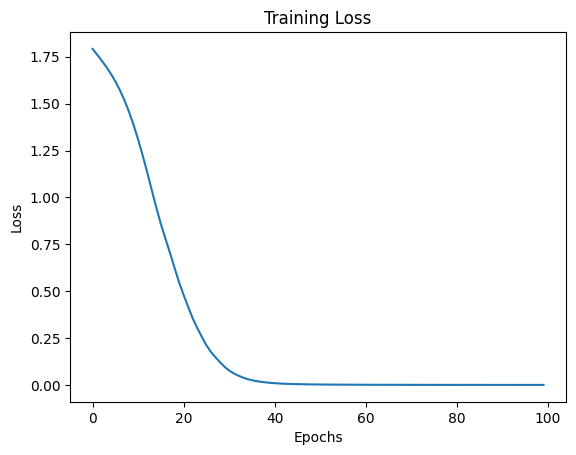

In [24]:
# Plotting training loss
import matplotlib.pyplot as plt
print(history_glorot_adam.history.keys())
plt.plot(history_glorot_adam.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()